# EDA - FloorPlanCAD Dataset

In [22]:
from pathlib import Path
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

from utils.utils import load_yaml_config

cfg = load_yaml_config()
datasets_cfg = cfg["file_paths"]["datasets"]
DATASETS_DIR = datasets_cfg["root"]
datasets = Path(DATASETS_DIR)

cubi_casa_5k = datasets / datasets_cfg["relative_paths"]["cubi_casa_5k"]
floor_plan_cad = datasets / datasets_cfg["relative_paths"]["floor_plan_cad"]
floor_plans = datasets / datasets_cfg["relative_paths"]["floor_plans"]
house_expo = datasets / datasets_cfg["relative_paths"]["house_expo"]
mls_struct_fp = datasets / datasets_cfg["relative_paths"]["mls_struct_fp"]
msd = datasets / datasets_cfg["relative_paths"]["modified_swiss_dwellings"]
rent_3d = datasets / datasets_cfg["relative_paths"]["rent_3d"]
robin = datasets / datasets_cfg["relative_paths"]["robin"]
robin_pp = datasets / datasets_cfg["relative_paths"]["robin_pp"]
r_plan = datasets / datasets_cfg["relative_paths"]["r_plan"]
swiss_dwellings = datasets / datasets_cfg["relative_paths"]["swiss_dwellings"]
text_to_3d_house = datasets / datasets_cfg["relative_paths"]["text_to_3d_house"]

assert floor_plan_cad.is_dir, f"Invalid directory: {floor_plan_cad}"
floor_plan_cad

PosixPath('/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD')

In [2]:
splits = [f for f in floor_plan_cad.iterdir()]
print(splits)

ds = splits[-1]
ds

[PosixPath('/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/test-00'), PosixPath('/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-01'), PosixPath('/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-00')]


PosixPath('/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-00')

In [3]:
{f.suffix for f in ds.iterdir()}  # '' is a folder

{'', '.png', '.svg'}

In [4]:
# Get folders
folders = sorted(f for f in ds.iterdir() if not f.suffix)
folders

[PosixPath('/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-00/coco_vis')]

In [5]:
(
    sum(1 for _ in ds.glob("*") if _.is_file() and _.suffix == ".png"),
    sum(1 for _ in ds.glob("*") if _.is_file() and _.suffix == ".svg"),
)

(3760, 3760)

In [6]:
train1_ds = sorted(f for f in ds.iterdir())[:5]
train1_ds

[PosixPath('/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-00/0000-0002.png'),
 PosixPath('/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-00/0000-0002.svg'),
 PosixPath('/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-00/0000-0003.png'),
 PosixPath('/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-00/0000-0003.svg'),
 PosixPath('/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-00/0000-0005.png')]

In [7]:
coco_vis = folders[0]
print(f"file types: {set(f.suffix for f in coco_vis.iterdir())}")  # '' is a folder
sum(1 for _ in coco_vis.glob("*") if _.is_file())

file types: {'.png'}


3760

In [8]:
train1_ds_labels = sorted(f for f in coco_vis.iterdir())

## Visualisation

image_pair_idx: (0, 1)
image_pair: ('0000-0002.png', '0000-0002.svg')


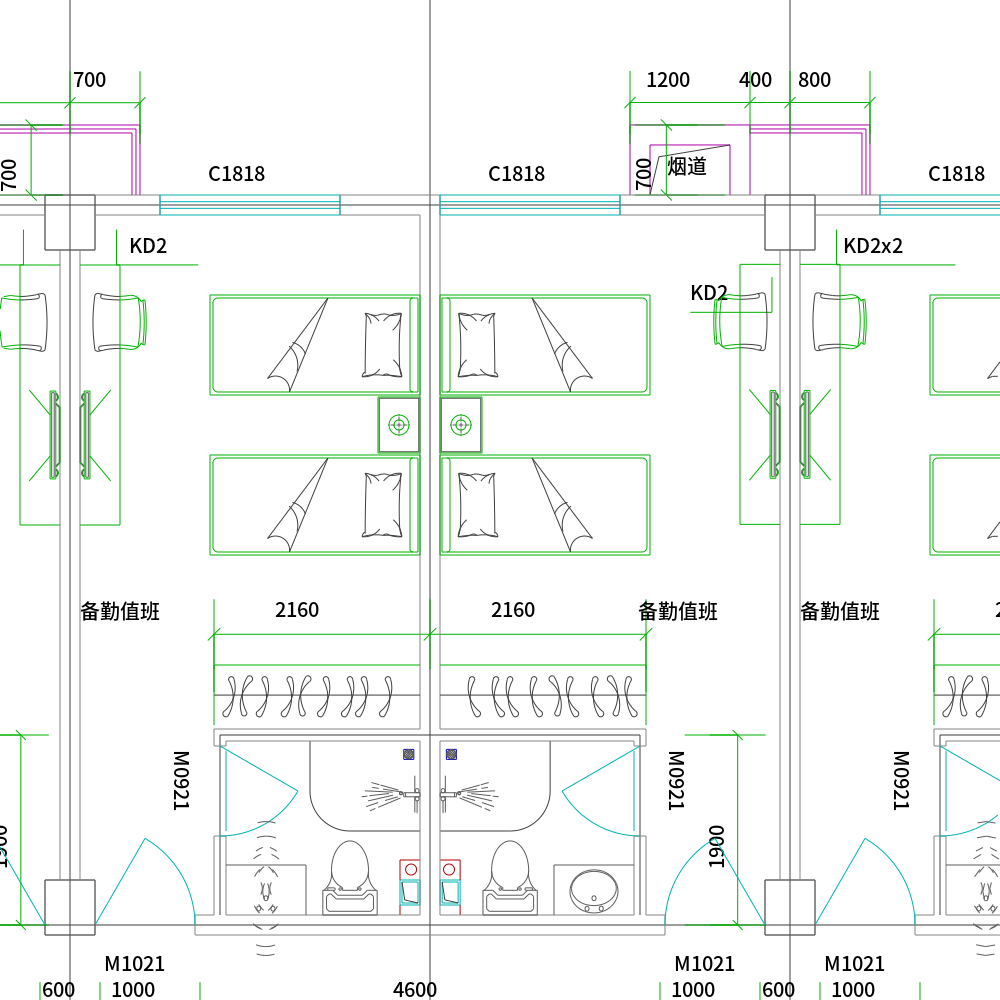

In [9]:
from PIL import Image

image_idx = 0

### Image
image_pair_idx = image_idx // 2, image_idx // 2 + 1
print(f"image_pair_idx: {image_pair_idx}")
png_image, svg_image = train1_ds[image_pair_idx[0]], train1_ds[image_pair_idx[1]]
print(f"image_pair: {png_image.name, svg_image.name}")

### Labels


### Visualisation
# PIL does not support SVG files
Image.open(png_image)

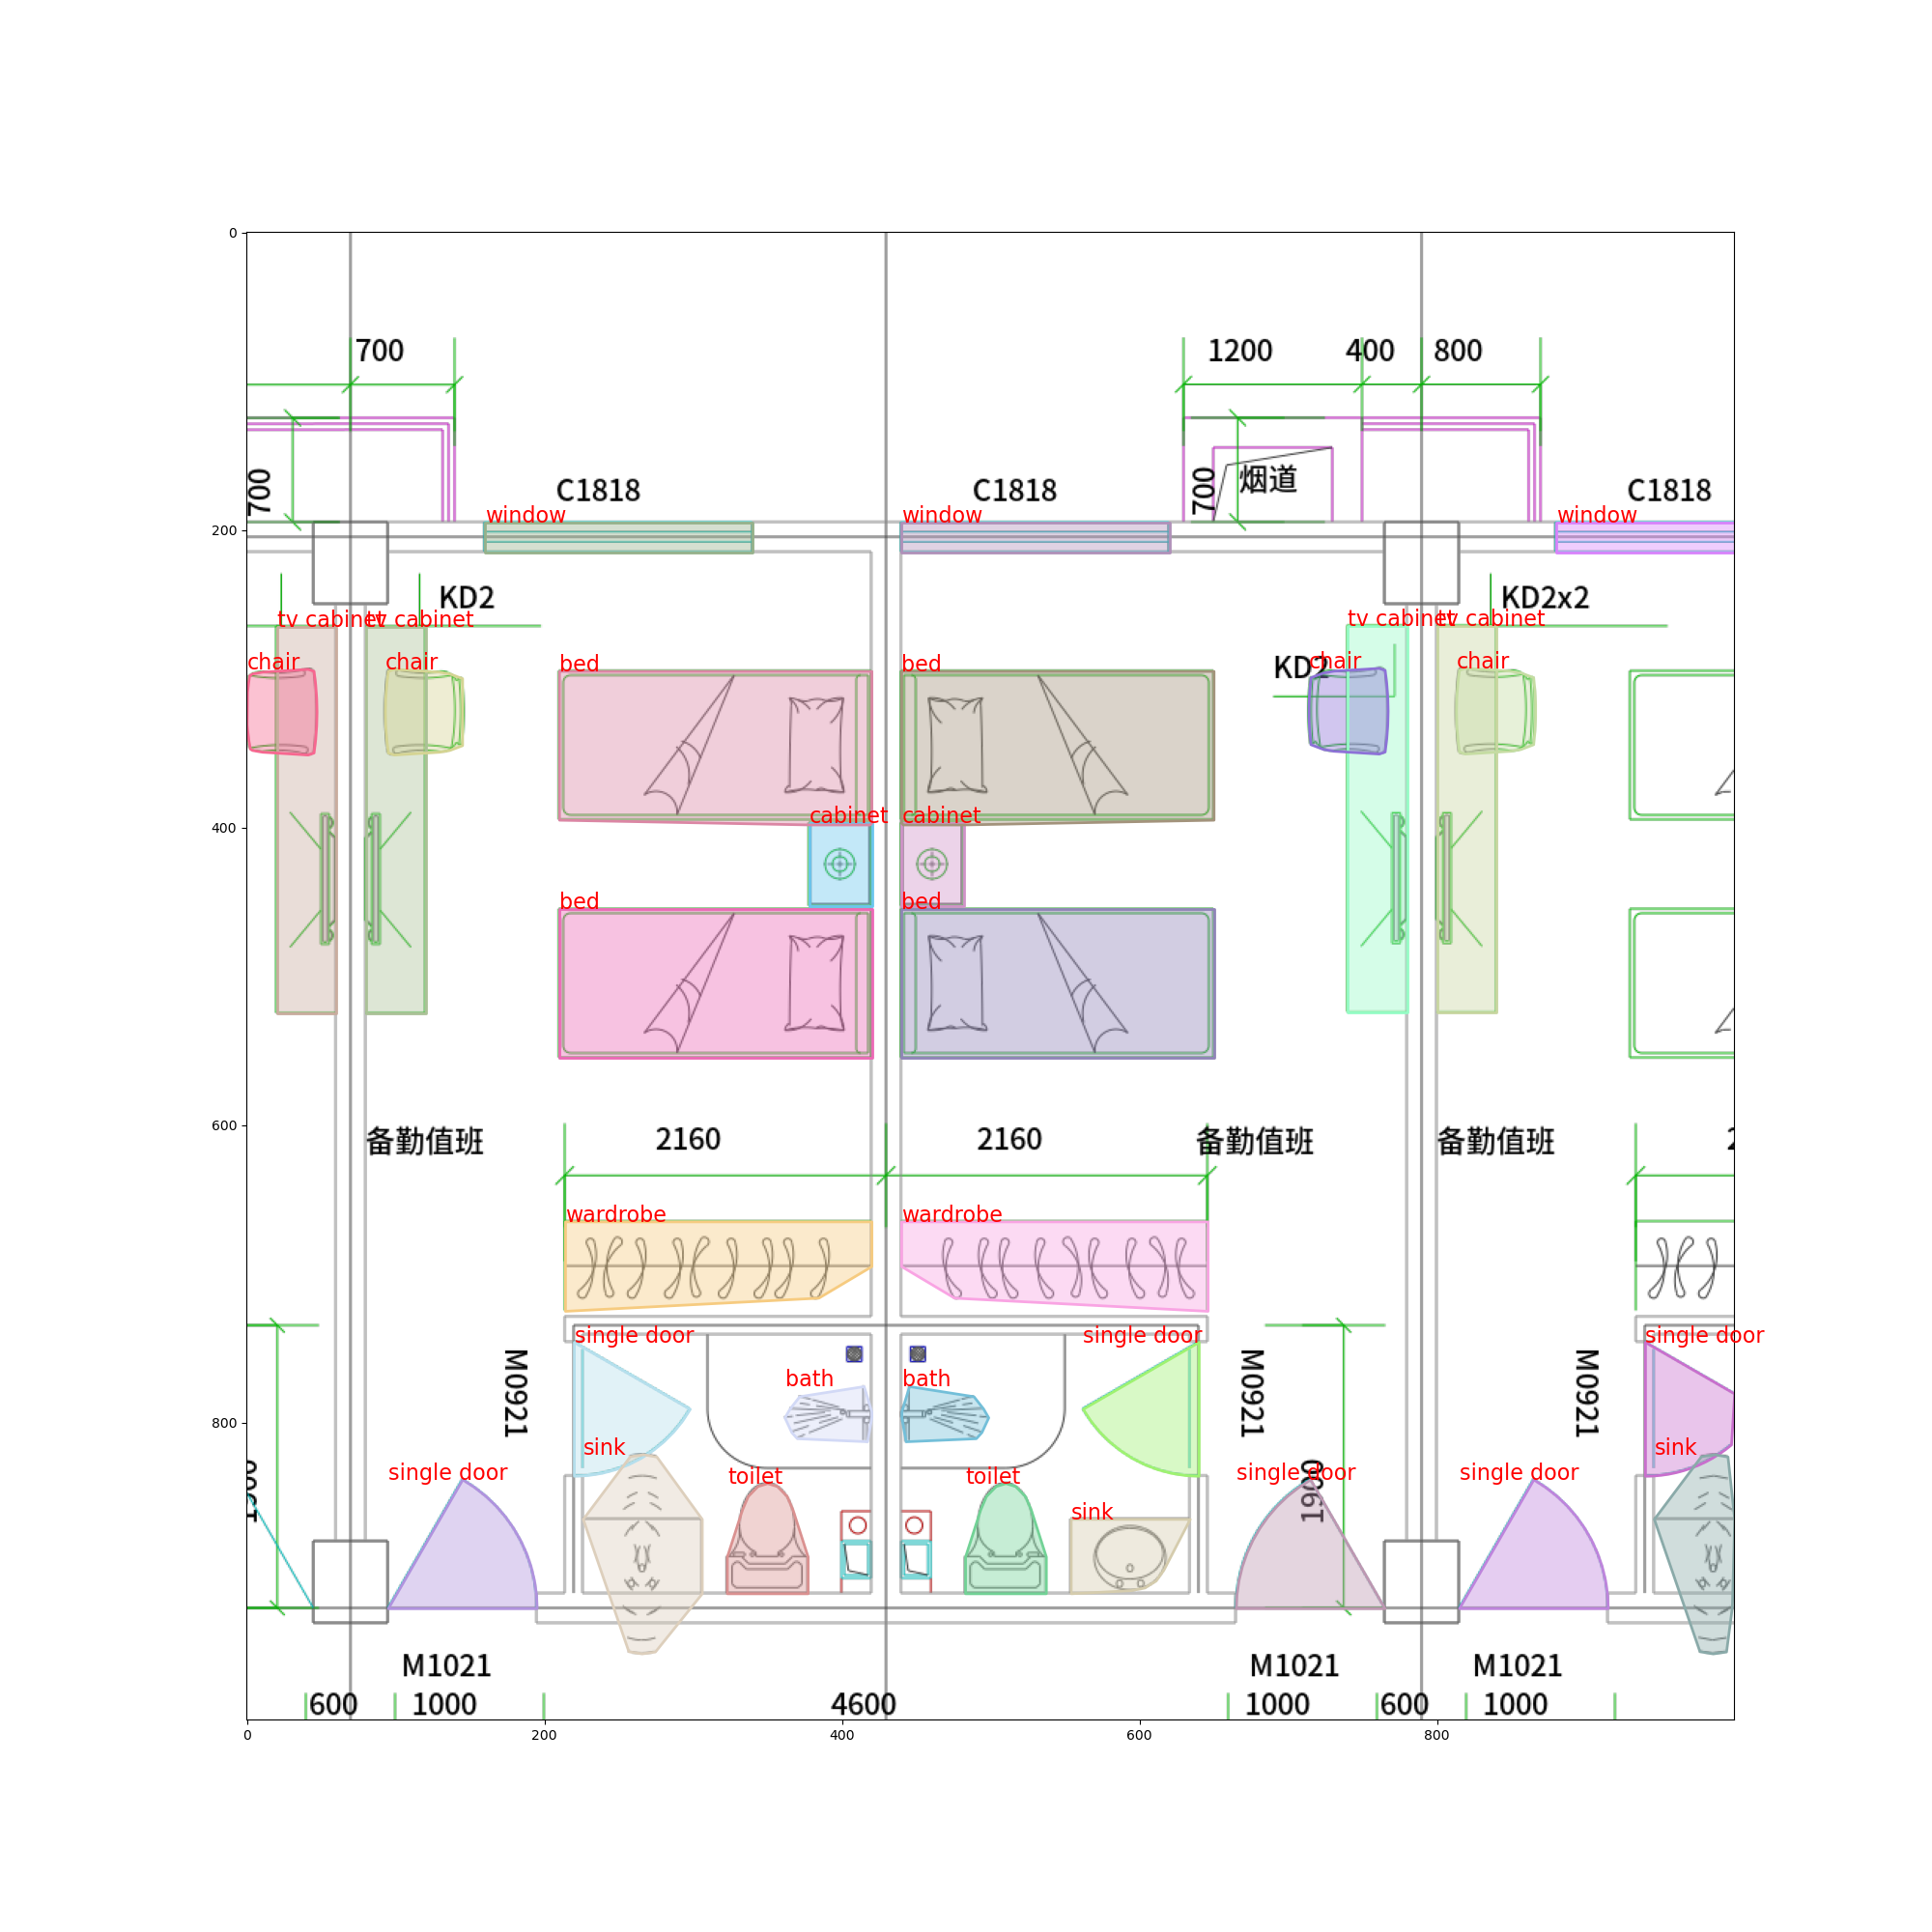

In [10]:
Image.open(train1_ds_labels[image_idx])

In [11]:
"""svg -> pytorch format """

import os
import math
import shutil
import argparse
import numpy as np
from glob import glob
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
from svgpathtools import parse_path
import multiprocessing as mp
from multiprocessing import Pool
from functools import partial
from utils_dataset import *
import torch


def parse_args(input_dir, output_dir, max_degree=128, visualize=False, thread_num=48):
    class Config:
        def __init__(
            self, input_dir, output_dir, max_degree=128, visualize=False, thread_num=48
        ):
            # Set default values
            self.input_dir = input_dir
            self.output_dir = output_dir
            self.max_degree = max_degree
            self.visualize = visualize
            self.thread_num = thread_num

        def __repr__(self):
            # Provide a string representation of the configuration
            return (
                f"Config(input_dir={self.input_dir}, output_dir={self.output_dir}, "
                f"max_degree={self.max_degree}, visualize={self.visualize}, thread_num={self.thread_num})"
            )

        def set(self, **kwargs):
            # Method to update attributes
            for key, value in kwargs.items():
                if hasattr(self, key):
                    setattr(self, key, value)
                else:
                    raise AttributeError(f"Config object has no attribute '{key}'")

        def get(self, key):
            # Method to retrieve attribute values
            if hasattr(self, key):
                return getattr(self, key)
            else:
                raise AttributeError(f"Config object has no attribute '{key}'")

    args = Config(
        input_dir=input_dir,
        output_dir=output_dir,
        max_degree=max_degree,
        visualize=visualize,
        thread_num=thread_num,
    )
    return args


def square_distance(src, dst):
    """Calculate Euclid distance between each two points using pytorch."""
    return torch.sum((src[:, :, None] - dst[:, None]) ** 2, dim=-1)


def get_nn(segments, max_degree=4):
    """Calculate the neighbors of each point"""
    segments = torch.Tensor(segments)
    nns_list = []
    for _, seg in enumerate(segments):
        i_start = seg[:2].unsqueeze(0).unsqueeze(0)
        i_end = seg[2:].unsqueeze(0).unsqueeze(0)

        p_start = segments[:, :2].unsqueeze(0)
        p_end = segments[:, 2:].unsqueeze(0)

        dist_istart_pstart = square_distance(i_start, p_start)[0, :]
        dist_istart_pend = square_distance(i_start, p_end)[0, :]
        dist_iend_pstart = square_distance(i_end, p_start)[0, :]
        dist_iend_pend = square_distance(i_end, p_end)[0, :]

        dist_cat = torch.cat(
            [dist_istart_pstart, dist_istart_pend, dist_iend_pstart, dist_iend_pend], 0
        )
        dist_min = torch.min(dist_cat, 0)[0]
        near_idx = dist_min.argsort()[:max_degree].numpy().tolist()

        nns_list.append(near_idx)
    return nns_list


def svg2graph(svg_path, output_dir, max_degree, visualize):
    """Construct the graph of each drawing"""
    tree = ET.parse(svg_path)
    root = tree.getroot()
    ns = root.tag[:-3]
    minx, miny, width, height = [
        int(float(x)) for x in root.attrib["viewBox"].split(" ")
    ]
    half_width = width / 2
    half_height = height / 2

    # get all segments
    segments = []
    nodes = []
    centers = []
    classes = []
    instances = []
    starts_ends = []
    for g in root.iter(ns + "g"):
        # path
        for path in g.iter(ns + "path"):
            try:
                path_repre = parse_path(path.attrib["d"])
            except Exception as e:
                raise RuntimeError(
                    "Parse path failed!{}, {}".format(svg_path, path.attrib["d"])
                )
            start = path_repre.point(0)
            end = path_repre.point(1)
            segments.append([start.real, start.imag, end.real, end.imag])
            # starts_ends.append([start.real, start.imag, end.real, end.imag, end.real, end.imag, start.real, start.imag])
            mid = path_repre.point(0.5)
            # length = math.sqrt((start.real - end.real) ** 2 + (start.imag - end.imag) ** 2)
            length = path_repre.length()
            nodes.append(
                [
                    length / width,
                    (mid.real - minx) / width,
                    (mid.imag - miny) / height,
                    1,
                    0,
                    0,
                ]
            )
            centers.append([mid.real, mid.imag])
            if "semanticId" in path.attrib:
                classes.append([int(path.attrib["semanticId"])])
            else:
                classes.append([0])
            if "instanceId" in path.attrib:
                instances.append([int(path.attrib["instanceId"])])
            else:
                instances.append([-1])
        # circle
        for circle in g.iter(ns + "circle"):
            cx = float(circle.attrib["cx"])
            cy = float(circle.attrib["cy"])
            r = float(circle.attrib["r"])
            segments.append([cx - r, cy, cx + r, cy])
            # starts_ends.append([cx - r, cy, cx + r, cy, cx + r, cy, cx - r, cy])
            nodes.append(
                [r * 2.0 / width, (cx - minx) / width, (cy - miny) / height, 0, 1, 0]
            )
            centers.append([cx, cy])
            if "semanticId" in circle.attrib:
                classes.append([int(circle.attrib["semanticId"])])
            else:
                classes.append([0])
            if "instanceId" in circle.attrib:
                instances.append([int(circle.attrib["instanceId"])])
            else:
                instances.append([-1])
        # ellipse
        for ellipse in g.iter(ns + "ellipse"):
            cx = float(ellipse.attrib["cx"])
            cy = float(ellipse.attrib["cy"])
            rx = float(ellipse.attrib["rx"])
            ry = float(ellipse.attrib["ry"])
            segments.append([cx - rx, cy, cx + rx, cy])
            # starts_ends.append([cx - rx, cy, cx + rx, cy, cx + r, cy, cx - r, cy])
            nodes.append(
                [(rx + ry) / width, (cx - minx) / width, (cy - miny) / height, 0, 0, 1]
            )
            centers.append([cx, cy])
            if "semanticId" in ellipse.attrib:
                classes.append([int(ellipse.attrib["semanticId"])])
            else:
                classes.append([0])
            if "instanceId" in ellipse.attrib:
                instances.append([int(ellipse.attrib["instanceId"])])
            else:
                instances.append([-1])

    segments = np.array(segments)
    nns = get_nn(copy.deepcopy(segments), max_degree=max_degree)
    if segments.shape[0] < 2:
        print("Warning: too few segments")
        return

    basename = os.path.basename(svg_path)

    if visualize:
        vis_path = os.path.join(output_dir, "./visualize/", basename)
        print(f"vis to {vis_path}")
        visualize_graph(root, centers, nns, vis_path)

    centers_norm = []
    for c in centers:
        centers_norm.append(
            [(c[0] - half_width) / half_width, (c[1] - half_height) / half_height]
        )
    data_gcn = {
        "nd_ft": nodes,
        "ct": centers,
        "cat": classes,
        "ct_norm": centers_norm,
        "nns": nns,
        "inst": instances,
    }
    npy_path = os.path.join(output_dir, basename.replace(".svg", ".npy"))
    np.save(npy_path, data_gcn)


def visualize_graph(root, centers, nns, vis_path):
    """Visualization of the constructed graph for verification"""
    ET.register_namespace("", "http://www.w3.org/2000/svg")
    g = ET.SubElement(
        root,
        "g",
        {
            "clip-path": "url(#clipId0)",
            "fill": "none",
            "stroke": "rgb(255,0,0)",
            "stroke-width": "0.25",
            "tag": "g",
        },
    )
    # for i in range(adj.shape[0]):
    #     s0, s1 = adj[i]
    #     s0cx, s0cy = centers[s0]
    #     s1cx, s1cy = centers[s1]
    #     polyline = ET.SubElement(g, 'polyline', {
    #         'points': '{0}, {1} {2}, {3}'.format(s0cx, s0cy, s1cx, s1cy),
    #         'tag': 'polyline'})

    # visualize center points
    # for i in range(len(centers)):
    #     s0cx, s0cy = centers[i]
    #     polyline = ET.SubElement(g, 'circle', {
    #         'cx': f'{s0cx}', 'cy': f'{s0cy}', "r":"0.1", "stroke":"rgb(255,0,0)", "fill":"rgb(255,0,0)",
    #         'tag': 'circle'})

    # visualize NNs
    for i in range(len(centers[:1])):
        s0cx, s0cy = centers[i]
        polyline = ET.SubElement(
            g,
            "circle",
            {
                "cx": f"{s0cx}",
                "cy": f"{s0cy}",
                "r": "0.5",
                "stroke": "rgb(255,0,0)",
                "fill": "rgb(255,0,0)",
                "tag": "circle",
            },
        )
        for j in range(len(nns[i][:16])):
            jj = nns[i][j]
            s0cx, s0cy = centers[jj]
            polyline = ET.SubElement(
                g,
                "circle",
                {
                    "cx": f"{s0cx}",
                    "cy": f"{s0cy}",
                    "r": "0.2",
                    "stroke": f"rgb(0,{15*j},0)",
                    "fill": f"rgb(0,{15*j},0)",
                    "tag": "circle",
                },
            )
    prettyxml = BeautifulSoup(ET.tostring(root, "utf-8"), "xml").prettify()
    with open(vis_path, "w") as f:
        f.write(prettyxml)

In [12]:
args = parse_args(input_dir=str(ds), output_dir=os.getcwd(), visualize=True)
os.makedirs(args.output_dir, exist_ok=True)
temp_dir = os.path.join(args.output_dir, "temp")
os.makedirs(temp_dir, exist_ok=True)
if args.visualize:
    os.makedirs(os.path.join(args.output_dir, "visualize"), exist_ok=True)

print(f"> svg -> npy")

svg_paths = sorted(glob(os.path.join(args.input_dir, "*.svg")))
svg_paths[:5]

> svg -> npy


['/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-00/0000-0002.svg',
 '/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-00/0000-0003.svg',
 '/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-00/0000-0005.svg',
 '/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-00/0001-0001.svg',
 '/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-00/0001-0002.svg']

In [13]:
partial_func = partial(
    svg2graph,
    output_dir=args.output_dir,
    max_degree=args.max_degree,
    visualize=args.visualize,
)

partial_func(svg_path=svg_paths[0])

vis to /home/yunusskeete/Documents/code/github/spaceform/yunusskeete/floor-plan-datasets/FloorPlanCAD/./visualize/0000-0002.svg


In [15]:
import numpy as np

data_dict = np.load("0000-0002.npy", allow_pickle=True).item()
data_dict.keys()

dict_keys(['nd_ft', 'ct', 'cat', 'ct_norm', 'nns', 'inst'])

In [23]:
str(svg_image)

'/home/yunusskeete/Documents/data/2D/Floor Plans/FloorPlanCAD/train-00/0000-0002.svg'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


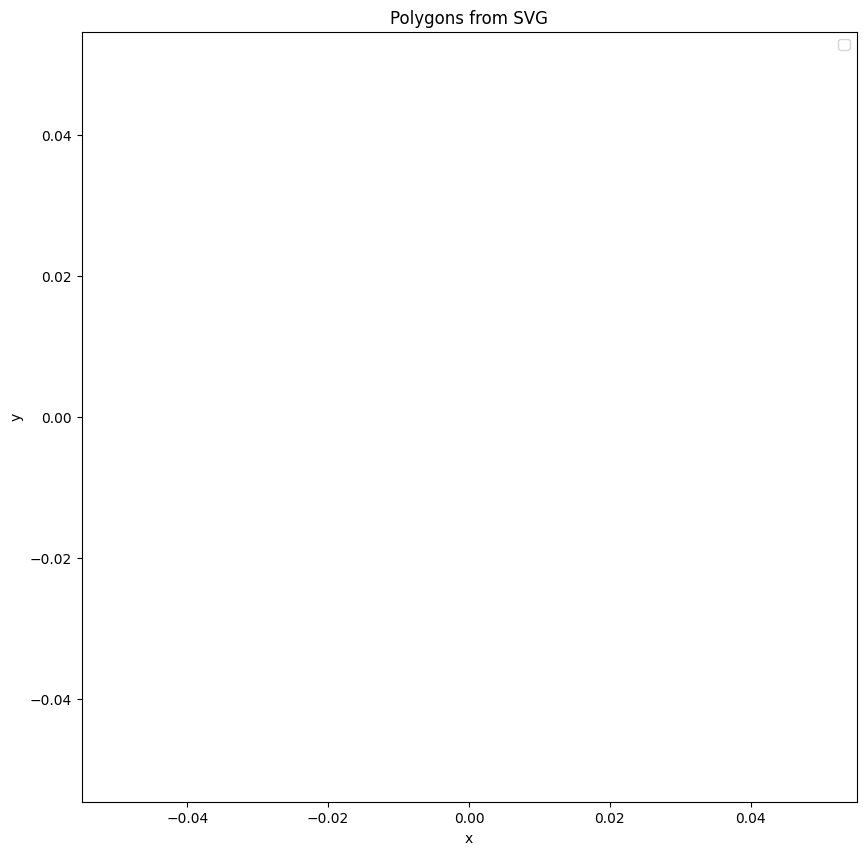

In [24]:
import svgpathtools as spt
import matplotlib.pyplot as plt

# Load the SVG file
svg_file = str(svg_image)
paths, attributes, _ = spt.svg2paths2(svg_file)

# Initialize the plot
plt.figure(figsize=(10, 10))
ax = plt.gca()

# Iterate through the extracted paths to find polygons
for path, attr in zip(paths, attributes):
    if "polygon" in attr.get("d", "") or attr.get("points"):
        # Extract the polygon points
        points_str = attr.get("points")
        if points_str:
            # Convert points from string to list of tuples
            points = [
                tuple(map(float, pt.split(","))) for pt in points_str.split(" ") if pt
            ]

            # Separate x and y coordinates for plotting
            x, y = zip(*points)

            # Plot the polygon
            ax.fill(x, y, label=f"Polygon ID: {attr.get('id')}", alpha=0.5)

# Set plot settings
ax.set_title("Polygons from SVG")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis("equal")
ax.legend()
plt.show()